## Assignment 1: Power Calendar function

In [180]:
import holidays
import re
from datetime import datetime
from datetime import timedelta 
import calendar

In [181]:
def get_hours(iso,peak_type,period):
    
    #This part use regular expression to class the input period and output the start and end date for the given period
    pattern1 = "([0-9]{4})-([0-9]{1,2})-([0-9]{1,2})"
    pattern2 = "([0-9]{4})(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)"
    pattern3 = "([0-9]{4})(Q)([1-4])"
    pattern4 = "([0-9]{4})A"
    
    if re.sub(pattern1,'1',period)=='1':
        year=re.sub(pattern1,'\\1',period)
        start_date=period
        end_date=period
    elif re.sub(pattern2,'1',period)=='1':
        year=re.sub(pattern2,'\\1',period)
        month=re.sub(pattern2,'\\2',period)
        month_number = datetime.strptime(month, '%b').month 
        _, num_days = calendar.monthrange(int(year), month_number)
        start_date=year+"-"+str(month_number)+"-1"
        end_date=year+"-"+str(month_number)+"-"+str(num_days)
    elif re.sub(pattern3,'1',period)=='1':
        year=re.sub(pattern3,'\\1',period)
        quater=re.sub(pattern3,'\\3',period)
        if quater==1:
            start_date=year+"-1-1"
            end_date=year+"-3-31"
        elif quater==2:
            start_date=year+"-4-1"
            end_date=year+"-6-30"
        elif quater==3:
            start_date=year+"-7-1"
            end_date=year+"-9-30"
        else:
            start_date=year+"-10-1"
            end_date=year+"-12-31"
    elif re.sub(pattern4,'1',period)=='1':
        year=re.sub(pattern4,'\\1',period)
        start_date=year+"-1-1"
        end_date=year+"-12-31"
    start_date=datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date=datetime.strptime(end_date, '%Y-%m-%d').date()
    year = int(year)
    nerc_holidays = holidays.US(years=year, observed=True)

    #This part determine which region we choose
    if iso in ["PJMISO", "MISO","ERCOT", "SPPISO", "NYISO"]:
        param=5
    else:
        param=6
        
    #This part is where we calculate number of hours
    if peak_type in ["onpeak","offpeak","flat"]:
        onpeak_hour=0
        flat_hour=0
        current_datetime = start_date
        while current_datetime <= end_date:
            current_datetime += timedelta(days=1)
            flag=False
            for date, name in nerc_holidays.items():
                if current_datetime.weekday()<param and date!=current_datetime:
                    flag=True
            if flag==True:
                onpeak_hour+=16
            flat_hour+=24
        offpeak_hour=flat_hour-onpeak_hour
        if peak_type=="onpeak":
            num_hour=onpeak_hour
        elif peak_type=="offpeak":
            num_hour=offpeak_hour
        elif peak_type=="flat":
            num_hour=flat_hour
    elif peak_type=="2*16H":
        num_hour=0
        current_datetime = start_date
        while current_datetime <= end_date:
            current_datetime += timedelta(days=1)
            flag=False
            for date, name in nerc_holidays.items():
                if current_datetime.weekday()>=param or date==current_datetime:
                    flag=True
            if flag==True:
                num_hour+=16
    elif peak_type=="7*8":
        num_hour=0
        current_datetime = start_date
        while current_datetime <= end_date:
            current_datetime += timedelta(days=1)
            num_hour+=8
            
    return([iso,peak_type,start_date,end_date,num_hour])

In [182]:
#Test the function
my_hour=get_hours("ERCOT", "2*16H", "2018A")
my_hour

['ERCOT',
 '2*16H',
 datetime.date(2018, 1, 1),
 datetime.date(2018, 12, 31),
 1808]

## Assignment 2: Meter Data formatting

In [183]:
import pandas as pd

In [184]:
# import and clean both dataset
df1 = pd.read_csv ('Assignment 2 - new.app4.csv')
df1 = df1.drop(columns="Unnamed: 0")
df1=df1.rename(columns={'time': 'DateTime'})
df1["W_min"]=df1["W_min"]/1000
df1['DateTime'] = pd.to_datetime(df1['DateTime'], format='%m/%d/%Y %H:%M')
df1['DateTime'] = df1['DateTime'].dt.floor('H')
df1 = df1.groupby(df1['DateTime'])['W_min'].sum().reset_index()
df2 = pd.read_csv ('Assignment 2 - USA_AL_Auburn-Opelika.AP.722284_TMY3_BASE.csv')
df2=df2.rename(columns={'Date/Time': 'DateTime'})
for i in range(len(df1["DateTime"])):
    output = df1.loc[i,"DateTime"].strftime('%m/%d %H:%M')
    df1.loc[i,"DateTime"]=output
pattern = "(.*)(24:00:00)"
for i in range(len(df2["DateTime"])):
    if re.sub(pattern,'1',df2.loc[i,"DateTime"])=='1':
        df2.loc[i,"DateTime"]=re.sub(pattern,'\\1',df2.loc[i,"DateTime"])+"00:00:00"
        date_time = datetime.strptime(df2.loc[i,"DateTime"].lstrip(), '%m/%d %H:%M:%S')
        next_day = date_time + timedelta(days=1)
        out = next_day.strftime('%m/%d %H:%M')
        df2.loc[i,"DateTime"]=out
    else:    
        date_time = datetime.strptime(df2.loc[i,"DateTime"].lstrip(), '%m/%d %H:%M:%S')
        out = date_time.strftime('%m/%d %H:%M')
        df2.loc[i,"DateTime"]=out

In [185]:
df1.head()

,DateTime,W_min
0,06/07 11:00,57.388943
1,06/07 12:00,27.227961
2,06/07 13:00,111.476298
3,06/07 14:00,109.021960
4,06/07 15:00,5.773963


In [186]:
df2.head()

,DateTime,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly)
0,01/01 01:00,0.974334,4.452977,0.0,4.425010,0.0,0.112709,0.112709,0.112709,0.154019,0.033180,0.092943,0.406035,0.158803
1,01/01 02:00,0.796582,4.850317,0.0,4.824566,0.0,0.122617,0.122617,0.122617,0.089845,0.019355,0.076186,0.373851,0.098084
2,01/01 03:00,0.735028,5.037645,0.0,5.012193,0.0,0.127099,0.127099,0.127099,0.064175,0.013825,0.062326,0.369517,0.081442
3,01/01 04:00,0.727433,5.107562,0.0,5.082468,0.0,0.128391,0.128391,0.128391,0.064175,0.013825,0.053976,0.364315,0.086107
4,01/01 05:00,0.778706,5.270878,0.0,5.246732,0.0,0.132549,0.132549,0.132549,0.064175,0.013825,0.065823,0.350553,0.135137


In [187]:
# Use dfply to merge the data by datetime
from dfply import *
merged_df = df1 >> inner_join(df2, by='DateTime')
merged_df['DateTime'] = pd.to_datetime(merged_df['DateTime'], format='%m/%d %H:%M')
for i in range(len(merged_df["DateTime"])):
    output = merged_df.loc[i,"DateTime"].strftime('%m/%d %H:%M')
    merged_df.loc[i,"DateTime"]=output
merged_df.head()

,DateTime,W_min,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly)
0,06/07 11:00,57.388943,1.479426,0.018757,0.0,0.0,0.347519,0.100007,0.447526,0.100007,0.047163,0.010160,0.360615,0.272322,0.324996
1,06/07 12:00,27.227961,1.559733,0.018441,0.0,0.0,0.454263,0.130764,0.585027,0.130764,0.047163,0.010160,0.350008,0.267735,0.282996
2,06/07 13:00,111.476298,1.702835,0.019079,0.0,0.0,0.603876,0.169912,0.773789,0.169912,0.047163,0.010160,0.319024,0.276993,0.259063
3,06/07 14:00,109.021960,1.859094,0.020153,0.0,0.0,0.752179,0.211629,0.963808,0.211629,0.047163,0.010160,0.294229,0.292590,0.234500
4,06/07 15:00,5.773963,2.100629,0.021274,0.0,0.0,0.921579,0.253177,1.174756,0.253177,0.050307,0.010837,0.301026,0.308854,0.238204


In [188]:
#This function allow user to specify a given period
def get_df(month1,day1,hour1,month2,day2,hour2):
    _merged_df = df1 >> inner_join(df2, by='DateTime')
    _merged_df['DateTime'] = pd.to_datetime(merged_df['DateTime'], format='%m/%d %H:%M')
    start_time = datetime(1900,month1, day1, hour1, 0)
    end_time = datetime(1900,month2, day2, hour2, 59)
    filtered_df = _merged_df >> mask((X.DateTime >= start_time) & (X.DateTime <= end_time))
    return(filtered_df)

In [189]:
filtered_df=get_df(6,10,11,7,15,23)

In [190]:
filtered_df.head()

,DateTime,W_min,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly)
18,1900-06-10 11:00:00,114.513788,1.427053,0.018757,0.0,0.0,0.246744,0.070927,0.317671,0.070927,0.047163,0.01016,0.413104,0.272322,0.349989
19,1900-06-10 12:00:00,109.916904,1.459188,0.018441,0.0,0.0,0.322353,0.092694,0.415047,0.092694,0.047163,0.01016,0.397819,0.267735,0.304620
20,1900-06-10 13:00:00,86.743821,1.603120,0.019079,0.0,0.0,0.478694,0.133155,0.611848,0.133155,0.047163,0.01016,0.362612,0.276993,0.277700
21,1900-06-11 12:00:00,86.163386,1.471146,0.018441,0.0,0.0,0.330399,0.098136,0.428535,0.098136,0.047163,0.01016,0.397819,0.267735,0.303090
22,1900-06-11 13:00:00,54.312595,1.487597,0.019079,0.0,0.0,0.381011,0.116681,0.497692,0.116681,0.047163,0.01016,0.362612,0.276993,0.276333


In [191]:
#total_energy_consumption column is add which is the sum of all columns except for datetime
merged_df["total_energy_consumption"]=merged_df.drop("DateTime", axis=1).sum(axis=1)
merged_df.head()

,DateTime,W_min,Electricity:Facility [kW](Hourly),Gas:Facility [kW](Hourly),Heating:Electricity [kW](Hourly),Heating:Gas [kW](Hourly),Cooling:Electricity [kW](Hourly),HVACFan:Fans:Electricity [kW](Hourly),Electricity:HVAC [kW](Hourly),Fans:Electricity [kW](Hourly),General:InteriorLights:Electricity [kW](Hourly),General:ExteriorLights:Electricity [kW](Hourly),Appl:InteriorEquipment:Electricity [kW](Hourly),Misc:InteriorEquipment:Electricity [kW](Hourly),Water Heater:WaterSystems:Electricity [kW](Hourly),total_energy_consumption
0,06/07 11:00,57.388943,1.479426,0.018757,0.0,0.0,0.347519,0.100007,0.447526,0.100007,0.047163,0.010160,0.360615,0.272322,0.324996,60.897441
1,06/07 12:00,27.227961,1.559733,0.018441,0.0,0.0,0.454263,0.130764,0.585027,0.130764,0.047163,0.010160,0.350008,0.267735,0.282996,31.065016
2,06/07 13:00,111.476298,1.702835,0.019079,0.0,0.0,0.603876,0.169912,0.773789,0.169912,0.047163,0.010160,0.319024,0.276993,0.259063,115.828105
3,06/07 14:00,109.021960,1.859094,0.020153,0.0,0.0,0.752179,0.211629,0.963808,0.211629,0.047163,0.010160,0.294229,0.292590,0.234500,113.919095
4,06/07 15:00,5.773963,2.100629,0.021274,0.0,0.0,0.921579,0.253177,1.174756,0.253177,0.050307,0.010837,0.301026,0.308854,0.238204,11.407785


In [192]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

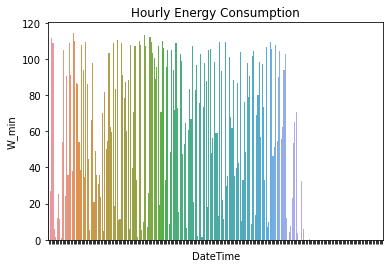

In [193]:
#Visualization
sns.barplot(x="DateTime", y="W_min", data=df1)
plt.gca().set_xticklabels([])
plt.title("Hourly Energy Consumption")
plt.show()

In [194]:
df2['DateTime'] = pd.to_datetime(df2['DateTime'],format='%m/%d %H:%M')
df2["total_energy_consumption"]=df2.drop("DateTime", axis=1).sum(axis=1)
weekday_df = df2[df2['DateTime'].dt.weekday < 5]

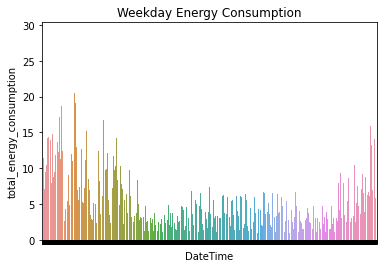

In [195]:
sns.barplot(x="DateTime", y="total_energy_consumption", data=weekday_df)
plt.gca().set_xticklabels([])
plt.title("Weekday Energy Consumption")
plt.show()

C:\Users\smral\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


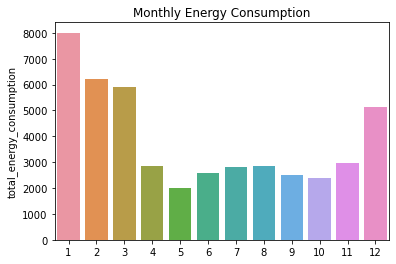

In [196]:
monthly_sum = df2.groupby(df2['DateTime'].dt.month)["total_energy_consumption"].sum()
x=list(range(1,13))
sns.barplot(x,monthly_sum)
plt.title("Monthly Energy Consumption")
plt.show()

## Assignment 3: EDA and forecast model

In [198]:
timeserie = pd.read_excel ('Assignment 3 - timeseries_data.xlsx')

In [199]:
timeserie.head()

,DATETIME,HB_NORTH (RTLMP),ERCOT (WIND_RTI),ERCOT (GENERATION_SOLAR_RT),ERCOT (RTLOAD),HOURENDING,MARKETDAY,PEAKTYPE,MONTH,YEAR
0,2017-01-01 01:00:00,23.3575,2155.31,0.0,29485.791355,1,2017-01-01,OFFPEAK,JANUARY,2017
1,2017-01-01 02:00:00,21.4650,2313.81,0.0,28911.565913,2,2017-01-01,OFFPEAK,JANUARY,2017
2,2017-01-01 03:00:00,20.7350,2587.68,0.0,28238.258175,3,2017-01-01,OFFPEAK,JANUARY,2017
3,2017-01-01 04:00:00,20.2700,2748.65,0.0,27821.000513,4,2017-01-01,OFFPEAK,JANUARY,2017
4,2017-01-01 05:00:00,20.1200,2757.49,0.0,27646.942413,5,2017-01-01,OFFPEAK,JANUARY,2017


In [200]:
# Summary Statistics
mean(timeserie["HB_NORTH (RTLMP)"])

25.766416607726704

In [201]:
sd(timeserie["HB_NORTH (RTLMP)"])

46.36194471206801

In [202]:
mean(timeserie["ERCOT (WIND_RTI)"])

7532.436282872779

In [203]:
sd(timeserie["ERCOT (WIND_RTI)"])

3992.884834380992

In [204]:
mean(timeserie["ERCOT (GENERATION_SOLAR_RT)"])

291.98971434291985

In [205]:
sd(timeserie["ERCOT (GENERATION_SOLAR_RT)"])

370.91459630619136

In [206]:
mean(timeserie["ERCOT (RTLOAD)"])

42371.6737026014

In [207]:
sd(timeserie["ERCOT (RTLOAD)"])

9874.339631258914

In [208]:
#Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(timeserie['HB_NORTH (RTLMP)'])
smoothed_values = model.fit().fittedvalues
timeserie['HB_NORTH (RTLMP)'] = smoothed_values

model = ExponentialSmoothing(timeserie['ERCOT (WIND_RTI)'])
smoothed_values = model.fit().fittedvalues
timeserie['ERCOT (WIND_RTI)'] = smoothed_values

model = ExponentialSmoothing(timeserie['ERCOT (GENERATION_SOLAR_RT)'])
smoothed_values = model.fit().fittedvalues
timeserie['ERCOT (GENERATION_SOLAR_RT)'] = smoothed_values

model = ExponentialSmoothing(timeserie['ERCOT (RTLOAD)'])
smoothed_values = model.fit().fittedvalues
timeserie['ERCOT (RTLOAD)'] = smoothed_values

C:\Users\smral\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\smral\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\smral\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\smral\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


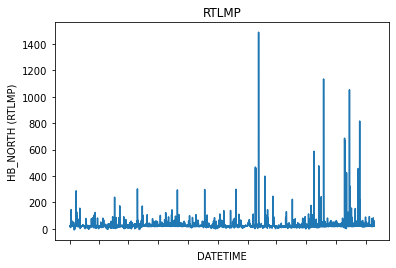

In [209]:
#Visualize each data
sns.lineplot(x="DATETIME", y="HB_NORTH (RTLMP)", data=timeserie)
plt.gca().set_xticklabels([])
plt.title("RTLMP")
plt.show()

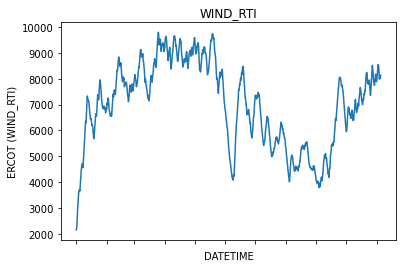

In [210]:
sns.lineplot(x="DATETIME", y="ERCOT (WIND_RTI)", data=timeserie)
plt.gca().set_xticklabels([])
plt.title("WIND_RTI")
plt.show()

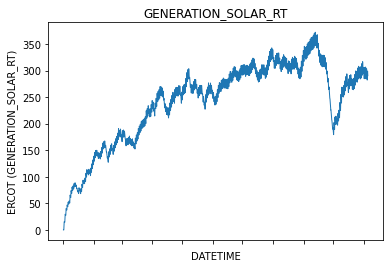

In [211]:
sns.lineplot(x="DATETIME", y="ERCOT (GENERATION_SOLAR_RT)", data=timeserie,linewidth=1)
plt.gca().set_xticklabels([])
plt.title("GENERATION_SOLAR_RT")
plt.show()

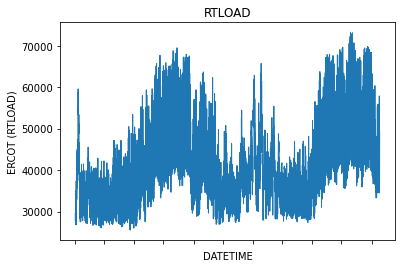

In [212]:
sns.lineplot(x="DATETIME", y="ERCOT (RTLOAD)", data=timeserie,linewidth=1)
plt.gca().set_xticklabels([])
plt.title("RTLOAD")
plt.show()

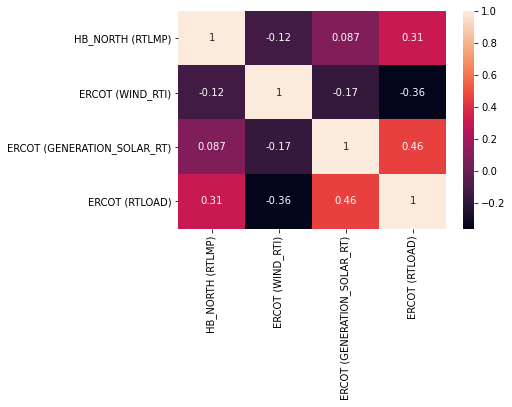

In [213]:
#Correlation
ax = sns.heatmap(timeserie.loc[:,["HB_NORTH (RTLMP)","ERCOT (WIND_RTI)","ERCOT (GENERATION_SOLAR_RT)","ERCOT (RTLOAD)"]].corr(), annot=True)

In [214]:
#Forcasting model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [215]:
timeserie=timeserie.dropna()
X=timeserie.loc[:,["ERCOT (WIND_RTI)","ERCOT (GENERATION_SOLAR_RT)","ERCOT (RTLOAD)"]]
y=timeserie.loc[:,"HB_NORTH (RTLMP)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [216]:
model = LinearRegression()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

In [217]:
train_error

195.68344917182526

In [218]:
test_error

132.7135399784833